In [1]:
import pandas as pd
from transformers import pipeline
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
import statsmodels.api as sm

In [ ]:
nlp = spacy.load("pt_core_news_lg")

def limpar_com_spacy(texto):
    # Corrige colagens comuns:
    texto = re.sub(r"([a-z])([A-Z])", r"\1 \2", texto)  
    texto = re.sub(r"([A-Z][a-z]{2,})([A-Z][a-z]{2,})", r"\1 \2", texto)  
    texto = re.sub(r"([a-zA-Z])(\d)", r"\1 \2", texto)  
    texto = re.sub(r"(\d)([a-zA-Z])", r"\1 \2", texto)  

    
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"\S+@\S+", "", texto)
    texto = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s]", "", texto)
    texto = re.sub(r"\s+", " ", texto).strip()

    
    doc = nlp(texto)

    
    tokens_limpos = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and not token.like_num and token.is_alpha
    ]

    return " ".join(tokens_limpos)

In [3]:
def extrair_empresas(texto):
    doc = nlp(texto)
    return [ent.text for ent in doc.ents if ent.label_ in ("ORG", "PRODUCT")]

In [ ]:
def aplicar_sentimento(caminho_csv, pasta_saida='outputs'):
    print("\n--- FinBERT-PT-BR ---")
    df = pd.read_csv(caminho_csv)
    pipe = pipeline("text-classification", model="lucas-leme/FinBERT-PT-BR")

    # Pré-processamento com spaCy
    #df['texto_limpo'] = df['texto'].apply(limpar_com_spacy)
    df['texto_limpo'] = df['texto'].astype(str).apply(limpar_com_spacy)
    df['empresas_mencionadas'] = df['texto'].apply(extrair_empresas)

    # Aplicar modelo FinBERT
    sentimentos = df['texto_limpo'].apply(lambda x: pipe(x[:512])[0])
    df['sentimento'] = sentimentos.apply(lambda s: s['label'])
    df['score_sentimento'] = sentimentos.apply(lambda s: s['score'])

    # novos campos
    os.makedirs(pasta_saida, exist_ok=True)
    nome_saida = os.path.basename(caminho_csv).replace('.csv', '_sentimento.csv')
    caminho_saida = os.path.join(pasta_saida, nome_saida)
    df.to_csv(caminho_saida, index=False, encoding='utf-8')
    print("Sentimentos salvos em:", caminho_saida)


    score_total = 0
    num_total = 0

    for _, row in df.iterrows():
        label = row['sentimento']
        score = row['score_sentimento']
        if label == 'positive':
            score_total += score
        elif label == 'negative':
            score_total -= score
        num_total += 1

    if num_total == 0:
        print("Nenhuma notícia classificada.")
        return

    media = score_total / num_total
    polaridade = (
        "Positive" if media >= 0.15 else
        "Negative" if media <= -0.15 else
        "Neutral"
    )
    print(f"Sentimento geral: {polaridade} (Score médio: {media:.3f})")

In [ ]:
if __name__ == '__main__':
    caminho = "C:\\Users\\femor\\OneDrive\\Área de Trabalho\\Analise de Sentimento\\Part01\\noticias"
    arquivos_csv = [f for f in os.listdir(caminho) if f.endswith('.csv')]

    for nome_arquivo in arquivos_csv:
        caminho_completo = os.path.join(caminho, nome_arquivo)
        #print(f"\nProcessando arquivo: {nome_arquivo}")
        aplicar_sentimento(caminho_completo)

In [189]:
pasta_saida = 'outputs'

arquivos_saida = [f for f in os.listdir(pasta_saida) if f.endswith('_sentimento.csv')]

for arquivo in sorted(arquivos_saida):
    caminho_completo = os.path.join(pasta_saida, arquivo)
    print(f"\n--- Visualizando: {arquivo} ---")
    #display(pd.read_csv(caminho_completo))


--- Visualizando: noticias_2025-05-01_sentimento.csv ---

--- Visualizando: noticias_2025-05-02_sentimento.csv ---

--- Visualizando: noticias_2025-05-03_sentimento.csv ---

--- Visualizando: noticias_2025-05-04_sentimento.csv ---

--- Visualizando: noticias_2025-05-05_sentimento.csv ---

--- Visualizando: noticias_2025-05-06_sentimento.csv ---

--- Visualizando: noticias_2025-05-07_sentimento.csv ---

--- Visualizando: noticias_2025-05-08_sentimento.csv ---

--- Visualizando: noticias_2025-05-09_sentimento.csv ---

--- Visualizando: noticias_2025-05-10_sentimento.csv ---

--- Visualizando: noticias_2025-05-11_sentimento.csv ---

--- Visualizando: noticias_2025-05-12_sentimento.csv ---

--- Visualizando: noticias_2025-05-13_sentimento.csv ---

--- Visualizando: noticias_2025-05-14_sentimento.csv ---

--- Visualizando: noticias_2025-05-15_sentimento.csv ---

--- Visualizando: noticias_2025-05-16_sentimento.csv ---

--- Visualizando: noticias_2025-05-17_sentimento.csv ---

--- Visualiza

C:\Users\femor\AppData\Local\Temp\ipykernel_6904\3106377193.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentimento', order=df['sentimento'].value_counts().index, palette='pastel')


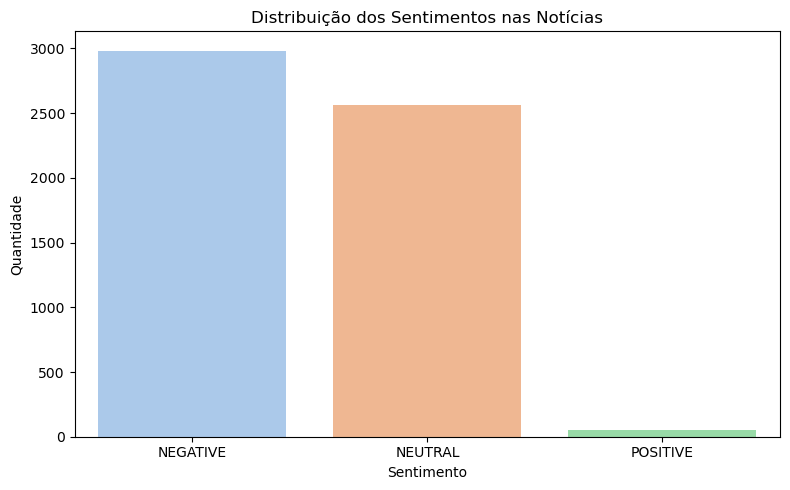

C:\Users\femor\AppData\Local\Temp\ipykernel_6904\3106377193.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentimento', y='score_sentimento', palette='muted')


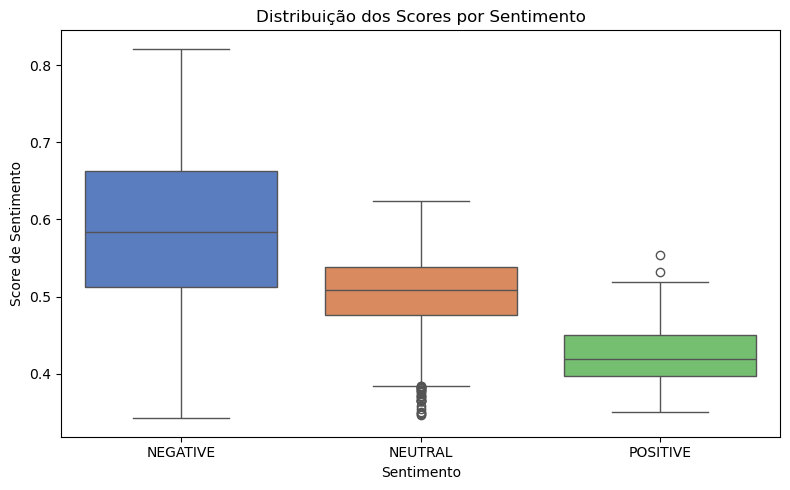

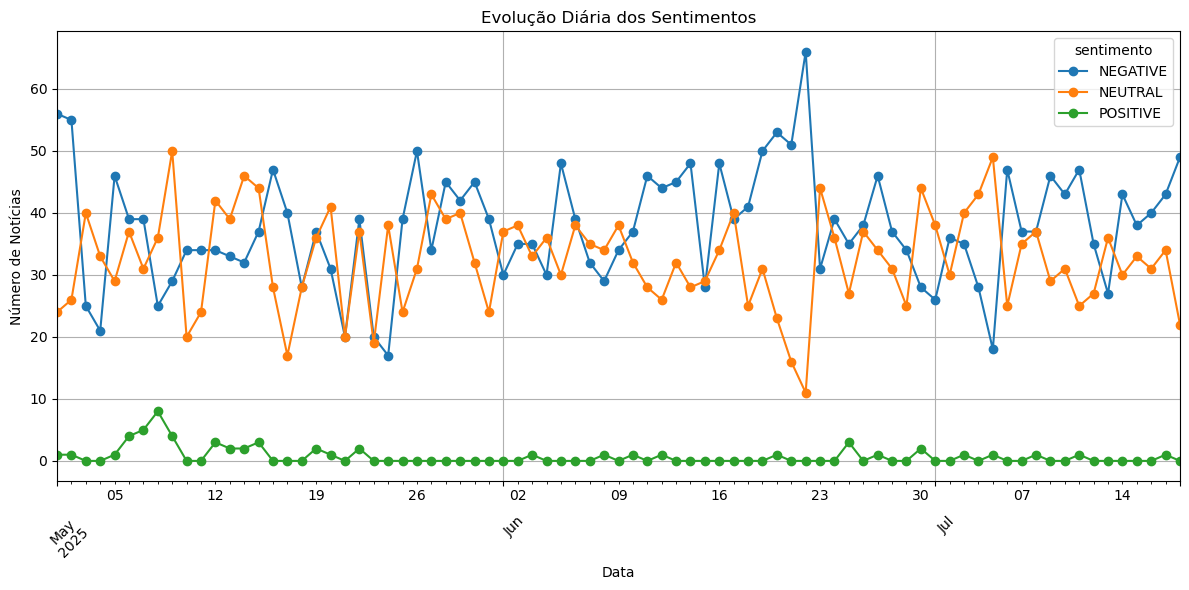

In [ ]:
pasta_outputs = r"C:\Users\femor\OneDrive\Área de Trabalho\Analise de Sentimento\outputs"

# Lista de todos os arquivos na pasta
arquivos = os.listdir(pasta_outputs)

# Filtrar apenas os arquivos CSV
arquivos_csv = [arquivo for arquivo in arquivos if arquivo.endswith(".csv")]

# Carregar e concatenar os arquivos CSV
lista_dfs = []
for nome_arquivo in arquivos_csv:
    caminho_completo = os.path.join(pasta_outputs, nome_arquivo)
    try:
        df_temp = pd.read_csv(caminho_completo)
        lista_dfs.append(df_temp)
    except Exception as e:
        print(f"Erro ao carregar {nome_arquivo}: {e}")

# Concatenar todos os DataFrames
df = pd.concat(lista_dfs, ignore_index=True)


df['data'] = pd.to_datetime(df['data'], errors='coerce')
df = df.dropna(subset=['data'])




plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentimento', order=df['sentimento'].value_counts().index, palette='pastel')
plt.title("Distribuição dos Sentimentos nas Notícias")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='sentimento', y='score_sentimento', palette='muted')
plt.title("Distribuição dos Scores por Sentimento")
plt.xlabel("Sentimento")
plt.ylabel("Score de Sentimento")
plt.tight_layout()
plt.show()


df_grouped = df.groupby(['data', 'sentimento']).size().unstack().fillna(0)
df_grouped.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Evolução Diária dos Sentimentos")
plt.xlabel("Data")
plt.ylabel("Número de Notícias")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Yahoo:

# Teste

In [141]:
petra =  yf.Ticker('PETR4.SA')

petra =  petra.history(period = 'max')

petra

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-02:00,1.338982,1.338982,1.338982,1.338982,35389440000,0.0,0.0
2000-01-04 00:00:00-02:00,1.264911,1.264911,1.264911,1.264911,28861440000,0.0,0.0
2000-01-05 00:00:00-02:00,1.252147,1.252147,1.252147,1.252147,43033600000,0.0,0.0
2000-01-06 00:00:00-02:00,1.247817,1.247817,1.247817,1.247817,34055680000,0.0,0.0
2000-01-07 00:00:00-02:00,1.253515,1.253515,1.253515,1.253515,20912640000,0.0,0.0
...,...,...,...,...,...,...,...
2025-07-30 00:00:00-03:00,32.299999,32.830002,32.270000,32.770000,27110400,0.0,0.0
2025-07-31 00:00:00-03:00,32.450001,32.750000,32.419998,32.639999,23544900,0.0,0.0
2025-08-01 00:00:00-03:00,32.799999,32.910000,32.040001,32.209999,24191800,0.0,0.0


In [142]:
petra.index

DatetimeIndex(['2000-01-03 00:00:00-02:00', '2000-01-04 00:00:00-02:00',
               '2000-01-05 00:00:00-02:00', '2000-01-06 00:00:00-02:00',
               '2000-01-07 00:00:00-02:00', '2000-01-10 00:00:00-02:00',
               '2000-01-11 00:00:00-02:00', '2000-01-12 00:00:00-02:00',
               '2000-01-13 00:00:00-02:00', '2000-01-14 00:00:00-02:00',
               ...
               '2025-07-23 00:00:00-03:00', '2025-07-24 00:00:00-03:00',
               '2025-07-25 00:00:00-03:00', '2025-07-28 00:00:00-03:00',
               '2025-07-29 00:00:00-03:00', '2025-07-30 00:00:00-03:00',
               '2025-07-31 00:00:00-03:00', '2025-08-01 00:00:00-03:00',
               '2025-08-04 00:00:00-03:00', '2025-08-05 00:00:00-03:00'],
              dtype='datetime64[ns, America/Sao_Paulo]', name='Date', length=6425, freq=None)

<Axes: xlabel='Date'>

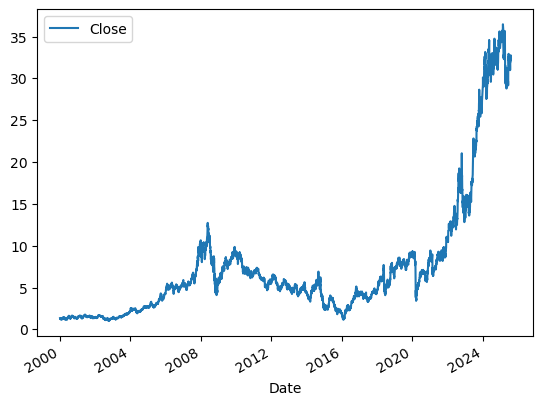

In [143]:
petra.plot.line(y = 'Close', use_index = True)

In [144]:
del petra['Dividends']
del petra['Stock Splits']

In [145]:
petra['Amanha'] = petra['Close'].shift(-1)

In [146]:
petra

,Open,High,Low,Close,Volume,Amanha
Date,,,,,,
2000-01-03 00:00:00-02:00,1.338982,1.338982,1.338982,1.338982,35389440000,1.264911
2000-01-04 00:00:00-02:00,1.264911,1.264911,1.264911,1.264911,28861440000,1.252147
2000-01-05 00:00:00-02:00,1.252147,1.252147,1.252147,1.252147,43033600000,1.247817
2000-01-06 00:00:00-02:00,1.247817,1.247817,1.247817,1.247817,34055680000,1.253515
2000-01-07 00:00:00-02:00,1.253515,1.253515,1.253515,1.253515,20912640000,1.279269
...,...,...,...,...,...,...
2025-07-30 00:00:00-03:00,32.299999,32.830002,32.270000,32.770000,27110400,32.639999
2025-07-31 00:00:00-03:00,32.450001,32.750000,32.419998,32.639999,23544900,32.209999
2025-08-01 00:00:00-03:00,32.799999,32.910000,32.040001,32.209999,24191800,32.160000


In [147]:
petra['Target'] = (petra['Amanha'] > petra['Close']).astype(int)

In [148]:
petra

,Open,High,Low,Close,Volume,Amanha,Target
Date,,,,,,,
2000-01-03 00:00:00-02:00,1.338982,1.338982,1.338982,1.338982,35389440000,1.264911,0
2000-01-04 00:00:00-02:00,1.264911,1.264911,1.264911,1.264911,28861440000,1.252147,0
2000-01-05 00:00:00-02:00,1.252147,1.252147,1.252147,1.252147,43033600000,1.247817,0
2000-01-06 00:00:00-02:00,1.247817,1.247817,1.247817,1.247817,34055680000,1.253515,1
2000-01-07 00:00:00-02:00,1.253515,1.253515,1.253515,1.253515,20912640000,1.279269,1
...,...,...,...,...,...,...,...
2025-07-30 00:00:00-03:00,32.299999,32.830002,32.270000,32.770000,27110400,32.639999,0
2025-07-31 00:00:00-03:00,32.450001,32.750000,32.419998,32.639999,23544900,32.209999,0
2025-08-01 00:00:00-03:00,32.799999,32.910000,32.040001,32.209999,24191800,32.160000,0


In [149]:
petra = petra.loc['2010-01-01':].copy()

In [150]:
petra

,Open,High,Low,Close,Volume,Amanha,Target
Date,,,,,,,
2010-01-04 00:00:00-02:00,9.152916,9.244569,9.120713,9.244569,13303600,9.165302,0
2010-01-05 00:00:00-02:00,9.259433,9.271818,9.115760,9.165302,21396400,9.289159,1
2010-01-06 00:00:00-02:00,9.115761,9.289159,9.115761,9.289159,18720600,9.202458,0
2010-01-07 00:00:00-02:00,9.232183,9.276771,9.182641,9.202458,10964600,9.152916,0
2010-01-08 00:00:00-02:00,9.204935,9.261908,9.130622,9.152916,14624200,9.123190,0
...,...,...,...,...,...,...,...
2025-07-30 00:00:00-03:00,32.299999,32.830002,32.270000,32.770000,27110400,32.639999,0
2025-07-31 00:00:00-03:00,32.450001,32.750000,32.419998,32.639999,23544900,32.209999,0
2025-08-01 00:00:00-03:00,32.799999,32.910000,32.040001,32.209999,24191800,32.160000,0


In [151]:
from sklearn.ensemble import RandomForestClassifier

In [152]:
model = RandomForestClassifier(n_estimators=100,min_samples_split=100, random_state= 1)

train = petra.iloc[:-100]
test = petra.iloc[-100:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']

model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [153]:
print(test[predictors].head())
print(type(test[predictors]))

                               Close    Volume       Open       High  \
Date                                                                   
2025-03-13 00:00:00-03:00  32.625710  19263600  32.379408  32.720444   
2025-03-14 00:00:00-03:00  33.629868  41529400  32.777278  33.876169   
2025-03-17 00:00:00-03:00  34.255100  31175900  33.734075  34.491930   
2025-03-18 00:00:00-03:00  34.283520  15086400  34.283520  34.491931   
2025-03-19 00:00:00-03:00  34.255100  21180500  34.359306  34.416147   

                                 Low  
Date                                  
2025-03-13 00:00:00-03:00  32.246784  
2025-03-14 00:00:00-03:00  32.559395  
2025-03-17 00:00:00-03:00  33.724600  
2025-03-18 00:00:00-03:00  34.018271  
2025-03-19 00:00:00-03:00  34.131948  
<class 'pandas.core.frame.DataFrame'>


In [154]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [155]:
preds = pd.Series(preds, index= test.index)

In [156]:
precision_score(test['Target'], preds)

0.6166666666666667

In [157]:
combined = pd.concat([test['Target'], preds], axis = 1)

<Axes: xlabel='Date'>

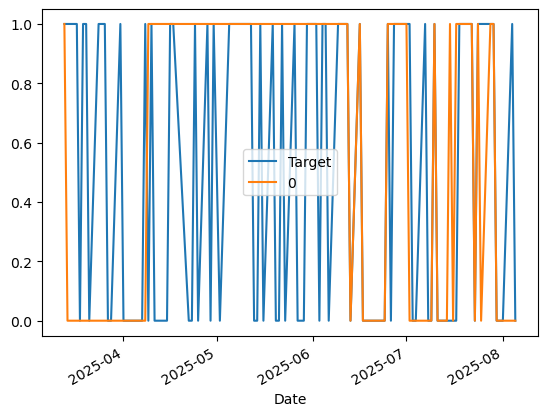

In [158]:
combined.plot()

In [159]:
def predict (train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict(test[predictors]) # retorna 0 ou 1
  preds = pd.Series(preds, index=test.index, name='Predictions')
  combined = pd.concat([test['Target'], preds],axis = 1)
  return combined

In [160]:
def backtest(data, model, predictors, start = 10, step=10):
  all_pred = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_pred.append(predictions)
  return pd.concat(all_pred)

In [161]:
predictions = backtest(petra, model, predictors)

In [162]:
predictions['Predictions'].value_counts()

Predictions
0    1971
1    1891
Name: count, dtype: int64

In [163]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5039661554732946

In [164]:
predictions['Target'].value_counts()/ predictions.shape[0]

Target
1    0.503107
0    0.496893
Name: count, dtype: float64

In [165]:
horizontes = [2,5,60,250,1000] # horizontes de média moveis

new_predictors = []

for horizonte in horizontes:
  media_movel = petra.rolling(horizonte).mean()

  close_column = f'Fechamento_{horizonte}'
  petra[close_column] = petra['Close'] / media_movel['Close']

  trend_column = f'Trend_{horizonte}'  # quando o stock subiu
  petra[trend_column] = petra.shift(1).rolling(horizonte).sum()['Target']

  # vamos olhar as datas passadas e ver a soma. Soma dos dias onde o preço de stock subiram

  new_predictors += [close_column, trend_column]

In [166]:
petra = petra.dropna()

In [167]:
petra # o pandas quando não acha dias o suficiente para computar uma média ele retorna nan

,Open,High,Low,Close,Volume,Amanha,Target,Fechamento_2,Trend_2,Fechamento_5,Trend_5,Fechamento_60,Trend_60,Fechamento_250,Trend_250,Fechamento_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2014-01-17 00:00:00-02:00,4.135237,4.148390,4.064212,4.079995,22865900,3.993186,0,0.997428,0.0,0.986516,1.0,0.854224,28.0,0.862773,118.0,0.688664,471.0
2014-01-20 00:00:00-02:00,4.064211,4.106300,3.982664,3.993186,17725000,4.035275,1,0.989247,0.0,0.972828,1.0,0.838172,28.0,0.845221,117.0,0.674600,471.0
2014-01-21 00:00:00-02:00,4.035275,4.035275,4.027384,4.035275,19893400,4.166802,1,1.005243,1.0,0.987639,2.0,0.849775,28.0,0.854891,118.0,0.682316,471.0
2014-01-22 00:00:00-02:00,4.056319,4.182586,4.016861,4.166802,44870600,4.069472,0,1.016036,2.0,1.022463,2.0,0.879674,29.0,0.883418,119.0,0.705156,472.0
2014-01-23 00:00:00-02:00,4.122083,4.185216,4.066841,4.069472,24150400,3.972142,0,0.988183,1.0,1.000129,2.0,0.861406,29.0,0.863466,119.0,0.689278,472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-29 00:00:00-03:00,32.189999,32.599998,31.990000,32.439999,33284000,32.770000,1,1.006516,2.0,1.011411,4.0,1.039350,32.0,0.990730,117.0,1.450489,527.0
2025-07-30 00:00:00-03:00,32.299999,32.830002,32.270000,32.770000,27110400,32.639999,0,1.005061,2.0,1.016755,4.0,1.047963,32.0,1.000649,118.0,1.463657,528.0
2025-07-31 00:00:00-03:00,32.450001,32.750000,32.419998,32.639999,23544900,32.209999,0,0.998013,1.0,1.008341,4.0,1.042009,31.0,0.996513,118.0,1.456292,527.0


In [168]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [169]:
def predict (train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict_proba(test[predictors])[:,1] # vai retornar uma prob de ser 0 ou 1 amanha
  preds[preds >= .6] = 1 # 6%
  preds[preds < .6] = 0 # o modelo precisa estar mais confiante de que o preço vai subir, para mostrar que o preço vai subir, assinm reduzindo os dias de negociações. Quando fazemos uma negociação, o preço realmente vai subir, mas não quero negociar todos os dias se não vou perder dinheiro

  preds = pd.Series(preds, index=test.index, name='Predictions')
  combined = pd.concat([test['Target'], preds],axis = 1)
  return combined

# modelo mais confiante nas previsões

In [170]:
predictions = backtest(petra, model, new_predictors)

In [171]:
predictions['Predictions'].value_counts()

Predictions
0.0    2519
1.0     342
Name: count, dtype: int64

In [172]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5263157894736842

In [ ]:
df['data'] = pd.to_datetime(df['data']).dt.date


df_sent_diario = df.groupby('data')['score_sentimento'].mean().rename("sentimento_medio").to_frame()


df_sent_diario.index = pd.to_datetime(df_sent_diario.index)

In [ ]:
petra = yf.Ticker('PETR4.SA').history(period='max')

del petra['Dividends']
del petra['Stock Splits']

# Cria a variável target: se o fechamento de amanhã for maior que o de hoje
petra['Amanha'] = petra['Close'].shift(-1)
petra['Target'] = (petra['Amanha'] > petra['Close']).astype(int)


petra = petra.loc['2010-01-01':].copy()


petra.index = petra.index.tz_localize(None)

In [175]:
# Faz o merge entre os dados da PETR4 e o sentimento médio por data
petra = petra.merge(df_sent_diario, left_index=True, right_index=True, how='left')

# apenas com os meus dias que tem noticias
petra = petra[petra['sentimento_medio'].notnull()]

In [ ]:
petra['MMS_7'] = petra['Close'].rolling(7).mean()
petra['MMS_30'] = petra['Close'].rolling(30).mean()


petra.fillna(0, inplace=True)

# Lista dos preditores para o modelo
new_predictors = ['Close', 'Volume', 'Open', 'High', 'Low', 'MMS_7', 'MMS_30', 'sentimento_medio']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score


def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined


def backtest(data, model, predictors, start=10, step=10):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)


resultados = backtest(petra, model, new_predictors)

# Calcula a precisão do modelo
precisao = precision_score(resultados['Target'], resultados['Predictions'])

print(f"Precisão do modelo: {precisao:.2%}")


Precisão do modelo: 44.44%


Target              1.000000
Volume              0.016353
MMS_30             -0.203120
MMS_7              -0.263694
sentimento_medio   -0.278831
High               -0.392636
Open               -0.400917
Low                -0.403448
Close              -0.417496
Name: Target, dtype: float64


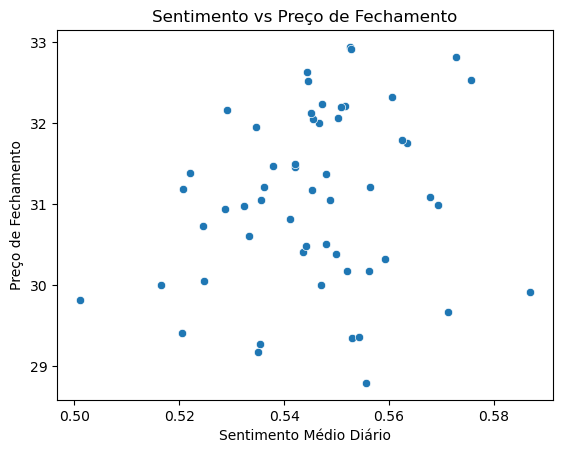

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlação entre predictors e o target
print(petra[new_predictors + ['Target']].corr()['Target'].sort_values(ascending=False))


sns.scatterplot(data=petra, x='sentimento_medio', y='Close')
plt.title("Sentimento vs Preço de Fechamento")
plt.xlabel("Sentimento Médio Diário")
plt.ylabel("Preço de Fechamento")
plt.show()


In [186]:
print(petra['sentimento_medio'].value_counts(dropna=False))

sentimento_medio
0.586953    1
0.541981    1
0.575623    1
0.551520    1
0.552568    1
0.552773    1
0.572730    1
0.546619    1
0.547958    1
0.536090    1
0.542147    1
0.556286    1
0.522017    1
0.545493    1
0.548747    1
0.529119    1
0.545101    1
0.550193    1
0.544529    1
0.560479    1
0.547204    1
0.544433    1
0.550778    1
0.534728    1
0.562511    1
0.537964    1
0.563393    1
0.524645    1
0.555550    1
0.541187    1
0.535408    1
0.520507    1
0.501014    1
0.516599    1
0.524453    1
0.520803    1
0.532429    1
0.528672    1
0.567847    1
0.535685    1
0.545271    1
0.543678    1
0.534956    1
0.544257    1
0.549854    1
0.533231    1
0.547997    1
0.559321    1
0.546995    1
0.556203    1
0.552056    1
0.552861    1
0.554338    1
0.571280    1
0.569379    1
Name: count, dtype: int64
